In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate
from io import BytesIO
from google.cloud import storage

In [4]:
np.random.seed(2)

In [5]:
bs = 64

In [6]:
#Random tranform for training model
tfms = get_transforms()
d_path = Path('data')

pd.read_csv(d_path/'labels.csv').head()

,image_id,healthy,multiple_diseases,rust,scab
0,train/Train_0.jpg,0,0,0,1
1,train/Train_1.jpg,0,1,0,0
2,train/Train_2.jpg,1,0,0,0
3,train/Train_3.jpg,0,0,1,0
4,train/Train_4.jpg,1,0,0,0


In [13]:
classes = ['healthy', 'multiple_diseases','rust','scab']
data = ImageDataBunch.from_csv(d_path, ds_tfms=tfms, label_col=classes, size=224, bs=bs)

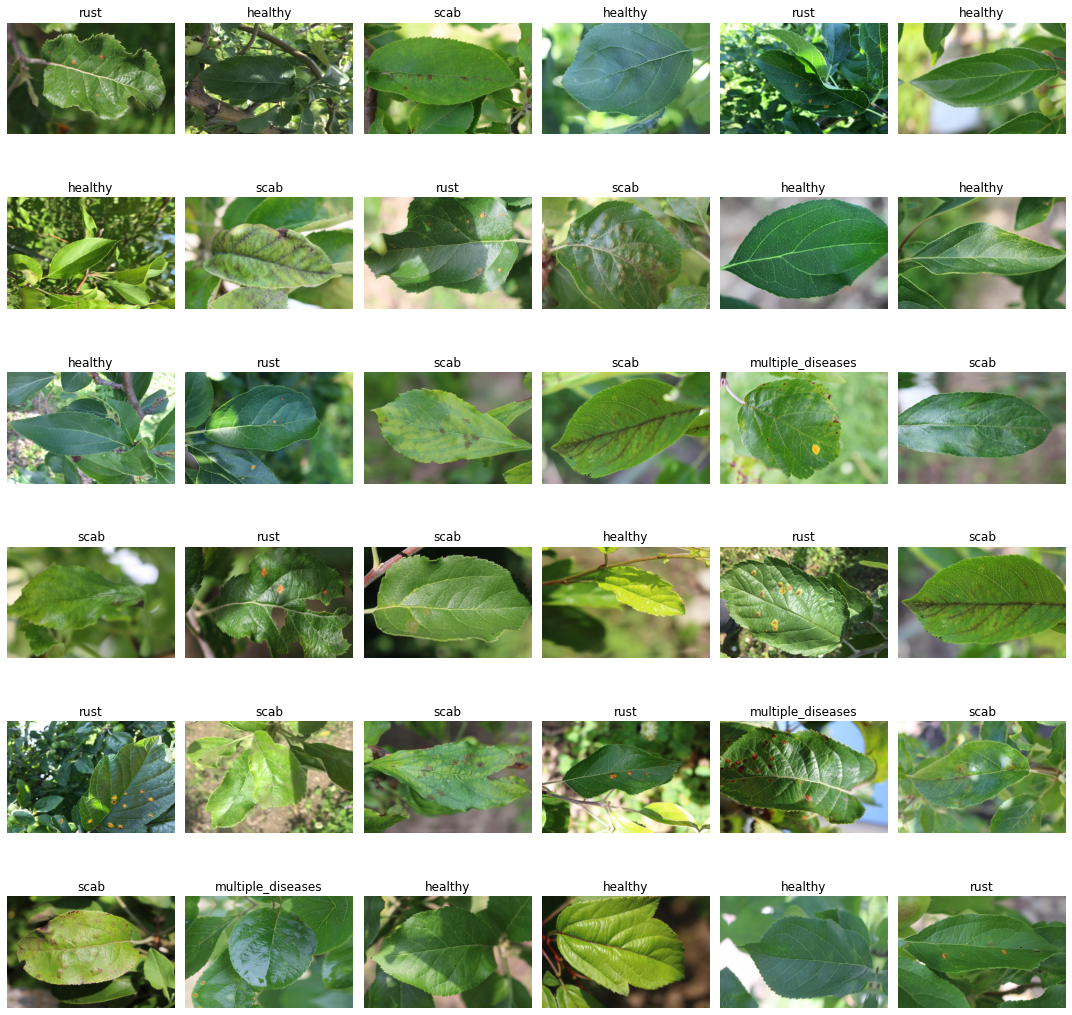

In [8]:
data.show_batch(rows=6, figsize=(15,15))

In [16]:
foliar_learner = cnn_learner(data, models.resnet34, metrics=error_rate)

In [17]:
foliar_learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.792128,0.467459,0.708104,00:44
1,0.560059,0.248207,0.765797,00:45
2,0.431671,0.197467,0.764423,00:44
3,0.353833,0.189028,0.776786,00:44


In [18]:
foliar_learner.save('stage-1')

In [21]:
foliar_learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


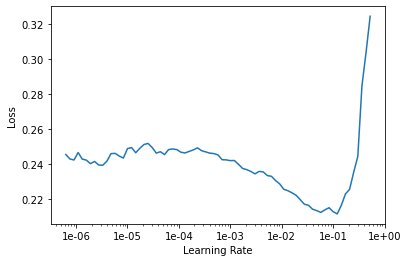

In [22]:
foliar_learner.recorder.plot()

__It looks like I have the least loss between 0.02 and 0.1__

In [23]:
foliar_learner.unfreeze()

In [24]:
foliar_learner.fit_one_cycle(2, slice(1e-2, 1e-1))

epoch,train_loss,valid_loss,error_rate,time
0,0.861446,4413916.000000,1.000000,00:45
1,0.673251,0.395749,0.843407,00:45


__Why did my error rate go from 1 percent to 84 percent???__

__What does that huge "valid loss" number mean on the first epoch?__

__Should I train train 1 epoch at a time, save every time and then just use the best result?__

In [26]:
foliar_learner = foliar_learner.load('stage-1')

In [27]:
foliar_learner.fit_one_cycle(1, slice(1e-2, 1e-1))

epoch,train_loss,valid_loss,error_rate,time
0,0.926652,2.758908,0.878434,00:46


__Reloading the learner and fitting it again with the same settings did nothing but make my error even worse. This is really disappointing. How do I get that 1 percent error back?__

In [28]:
interp =ClassificationInterpretation.from_learner(foliar_learner)

In [29]:
losses, idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

False

IndexError: index 1005 is out of bounds for axis 0 with size 364

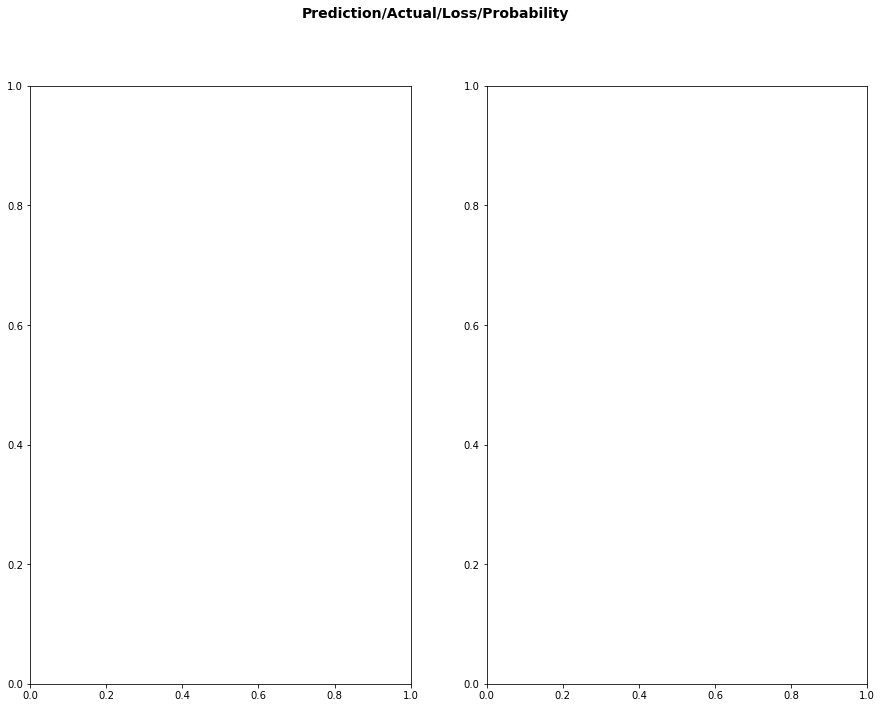

In [33]:
# This gives me an error rate no matter what numbers I use.
interp.plot_top_losses(2, figsize=(15,11))

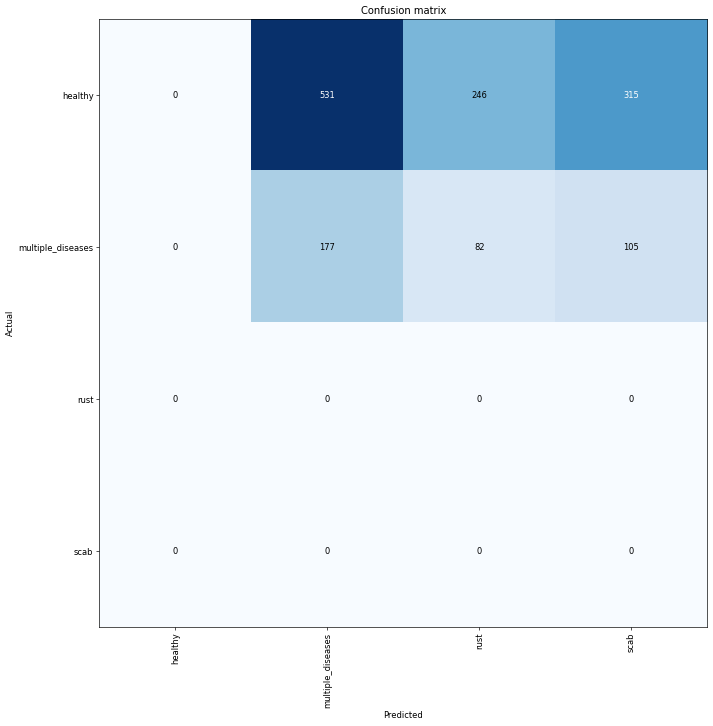

In [32]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

__Well, that's pretty horrible. It looks like the most confusion is between predicting "multiple diseases" that are actually "healthy"... I looked at some of the photos and have to agree. There are a lot of leaves marked "multiple diseases" that look perfectly healthy... and I grow apple trees, so I have some experience.__